In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tag import pos_tag
from nltk.tokenize import WordPunctTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from collections import Counter
import json

from encryptedpickle import encryptedpickle
import pickle
from facepy import GraphAPI
import credentials
from geotext import GeoText

import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Write retrieved data to pickle file

encoder = encryptedpickle.EncryptedPickle(signature_passphrases=credentials.passphrases,
                                         encryption_passphrases=credentials.passphrases)

encryption = {
    # Add new encryption algorithm specification with id = 255.
    # Default algorithms can not be overridden so we must use some other
    # id, maybe best starting with 255 (maximum id) and decreasing by one
    # for next added algorithm.
    255: {
        # Algorithm name defined in EncryptedPickle.ALGORITHMS.
        'algorithm': 'aes-256-cbc',

        # Salt size for PBKDF2 key.
        'salt_size': 32,

        # Digest mode for PBKDF2 key.
        'pbkdf2_algorithm': 'sha256',

        # Use 10 iterations in PBKDF2 key generation.
        'pbkdf2_iterations': 10,
    },
}

encoder.set_algorithms(encryption=encryption)



In [3]:
graph = GraphAPI(credentials.fbtoken)

In [4]:
content = graph.get('/10153515548171271/feed')

In [5]:
content

{u'data': [{u'actions': [{u'link': u'https://www.facebook.com/10153515548171271/posts/10154561134711271',
     u'name': u'Comment'},
    {u'link': u'https://www.facebook.com/10153515548171271/posts/10154561134711271',
     u'name': u'Like'}],
   u'created_time': u'2016-11-08T16:47:09+0000',
   u'from': {u'id': u'10153515548171271', u'name': u'Aaron Kim'},
   u'id': u'10153515548171271_10154561134711271',
   u'is_expired': False,
   u'is_hidden': False,
   u'likes': {u'data': [{u'id': u'10153119020437345', u'name': u'Queena Kim'},
     {u'id': u'10106326331063768', u'name': u'Jon A. Jo'},
     {u'id': u'10154972940430646', u'name': u'Rosette K. Lee'},
     {u'id': u'10203646744908206', u'name': u'David C. Lee'},
     {u'id': u'989136211139371', u'name': u'Efren Fradejas'},
     {u'id': u'428760387268799', u'name': u'Mark Kang'},
     {u'id': u'10153481552898825', u'name': u'Edward Chang'},
     {u'id': u'10101235205879531', u'name': u'Suzy Yim'},
     {u'id': u'10152947140887478', u'nam

In [6]:
sealed = encoder.seal(content)

In [7]:
print("* sealed: %s" % sealed)

* sealed: EPAQAAAAABAAAAQ2M9OOxzjQk1a2hclaSqZW3j1kr7SxUj6gKj36KxwaH9vyi_N3jdFsPux3HuFDptNel-kUbMrhCtsvn0kZmdCykF9LZYK9seBoOk_gtGQOP68yLIUtrfdOglAUwFnMYzM47cbxQIHrvzcDebwsdrZ_1aryy8oT9Vn2vaC-ZxGPt7xKn9QdEvG77EA564ZpFFOJmMpK9gcMnWl-XyeI3s9_rzvNVtILJyNrjwYQvQYdJW2YHkMsU5EZ308H3ihTsB6z1yzUt8ZNmI9sGmxkNDRAtggy3Vp7-Hb1U34Dzxlt2Gh7zutPaflPZYMp-WLV1wcMMVKRUP-ajibziPwxFcjvCGdL4kGIqdf_F5EemBWyx3K_PFdoIEGIpbLImQN71LSeGjpIu-5Kq9WLGGypMRIOuCbU4XQ0qN2QmkbTF7T1Ur1iYpTgKvlK64GjC6oiFEIek0WI3SL8Zv8SfEod45aYeXoc-0qAiUTPNkatq5eOI9tu0aCvmDQg32hCu3jIg0-bxzjMbgMYzt-Nn2qZmAtwA4H4Vcc5ISPnp93LY9bKfYoH-16qGMqixxhqWhTTrJIl2dm7jonZCVMOwqVpykI9HjoXOvEp7Y8Yk0l9HD6Iqxy8o9AssayvH6clBM0i6lKjYEKhue6CUm6HZKxpJQXbh7nghAqOKa6ksY7BWdFWZT3lznNGHi1hnM-TwjLSdD_lgjR--XAUrFfotQf5OjtKABqdk-pxhkbufVv2DUOGCRmQkTKivRc55cFt3dtkZVc2Nohvuj71dKpex8Ozk-xa4PBRbbnu_6TRUlizCEQhc7tQdzTcpQFYeKlsAMDQD2akTiADxOBatquqP1Rdja20CLtFuVoWWZdETc6PGYIMjBF3wJMLfTYqODlEje5_2A3phFabnQZD9FEgT7Ati82flPQ7bE4Y7UdMymbiDLVOrGCUyFqsGVpY83wG1PY9QRrRlEhOdjcBIbsRsj

In [8]:
with open('fbfeed.p','wb') as fp:
    pickle.dump(sealed,fp)

In [3]:
# Loading pickle data from file (if necessary)

with open('fbfeed.p','rb') as fp:
    sealedcontent = pickle.load(fp)

unsealed = encoder.unseal(sealedcontent)

In [4]:
type(unsealed)

dict

In [5]:
locations = {}

messages = []

for post in unsealed['data']:
    try:
        print 'Title:%s'%post['name']
        print 'Time:%s'%post['created_time']
        print 'Message:%s'%post['message']
        print 'Location:%s'%post['place']['location']
        locations.update({post['created_time']:post['place']['location']})
    except:
        pass
    print "-------"


-------
Title:Instagram photo by Aaron Kim • Nov 8, 2016 at 4:46pm UTC
Time:2016-11-08T16:46:25+0000
Message:Had to do my part to make sure no  burgers were dropped today. Get yours!
-------
-------
-------
Title:Instagram photo by Aaron Kim • Nov 1, 2016 at 5:42am UTC
Time:2016-11-01T05:42:35+0000
Message:Tagged along for a Halloween hike w the good folks at Christfit. Good way to start the week! But it's already November. Where'd the year go??
Location:{'city': 'Altadena', 'zip': '91001', 'country': 'United States', 'longitude': -118.13054080357, 'state': 'CA', 'latitude': 34.204032626371}
-------
Title:Instagram photo by Aaron Kim • Oct 29, 2016 at 9:13pm UTC
Time:2016-10-29T21:17:43+0000
Message:Was looking for a costume but took a detour and got distracted. 😬
Location:{'city': 'Los Angeles', 'zip': '90012', 'country': 'United States', 'longitude': -118.24051062316, 'state': 'CA', 'street': '134 Japanese Village Plaza, Bldg E', 'latitude': 34.048925395375}
-------
-------
Title:Kmo

In [6]:
locations

{'2016-10-29T21:17:43+0000': {'city': 'Los Angeles',
  'country': 'United States',
  'latitude': 34.048925395375,
  'longitude': -118.24051062316,
  'state': 'CA',
  'street': '134 Japanese Village Plaza, Bldg E',
  'zip': '90012'},
 '2016-11-01T05:42:35+0000': {'city': 'Altadena',
  'country': 'United States',
  'latitude': 34.204032626371,
  'longitude': -118.13054080357,
  'state': 'CA',
  'zip': '91001'}}

In [7]:
fblocdata = []
columns = []

for timestamp in locations.keys():
    columns = locations[timestamp].keys() if len(locations[timestamp].keys()) > len(columns) else columns
    
    fbdataholder= []
    for title in columns:
        try:
            fbdataholder.append(locations[timestamp][title])
        except:
            fbdataholder.append('nan')
    
    fblocdata.append(fbdataholder)

fblocdf = pd.DataFrame(fblocdata,columns=columns)
    
print 'Given the available Facebook post data, the following location data is available:'
fblocdf

Given the available Facebook post data, the following location data is available:


,city,zip,country,longitude,state,street,latitude
0,Los Angeles,90012,United States,-118.240511,CA,"134 Japanese Village Plaza, Bldg E",34.048925
1,Altadena,91001,United States,-118.130541,CA,nan,34.204033


# ==== LOCATION BASED CHALLENGE (LBC) ====

The concept of this approach is to take user location data (if available) and try to build a challenge option based on the location data available.

Google maps user location history is enabled by default and running in the background, so it's reasonable to assume this data is readily available.

Some things to consider when deciding to include an LBC are:
- Date of last location : for now, the null hypothesis/assumption about the user's ability to retain their own location information is that they will be able to recall where they were with reasonable accuracy for up to three days worth of history. This assumption will need to be tested and will need to be updated accordingly in effort to improve the location recollection success rate over time.
- If the data is a pair of geographic coordinates but no specific business/name reference, is there user history with reference to any businesses or other frequent markers that can be tied to the user? 
    - eg: have a pair of coordinates for the corner of Washington and Hill. There is a subway, chinese restaurant, mcdonalds, courthouse, and maker city LA/General Assembly. Is there user history to suggest which one (or more) of these were visited by the user? 

## Source : Google Maps Data

In [8]:
g_loc_hist_raw = pd.read_json('LocationHistory.json')

In [9]:
len(g_loc_hist_raw)

140

In [10]:
# Added new data available from 11/07
g_loc_hist2_raw = pd.read_json('LocationHistory-20161107.json')

In [11]:
len(g_loc_hist2_raw)

502

In [12]:
gmaps_columns = ['timestamp','lat','lng','acc','vel','heading','altitude','v_acc']

In [13]:
# Google maps location does not include the decimal point. 
# The code below is to set the offset programmatically in 
# case there is a need to do so in the future. 

gmaps_coord_disp = 10.**7

In [14]:
def pandify_gloc_data(data, columns, geodisp = 10.**7):
    loc_hist = []
        
    for datapoint in data:
        try:
            timestamp = datetime.datetime.fromtimestamp((int(datapoint['timestampMs'])/1000)).strftime('%Y-%m-%d %H:%M:%S')
        except:
            timestamp = ''
        try:
            lat = datapoint['latitudeE7']/(geodisp)
        except:
            lat = '0'
        try:
            lng = datapoint['longitudeE7']/(geodisp)
        except:
            lng = '0'
        try:
            alt = datapoint['altitude']
        except:
            alt = '0'
        try:
            v_acc = datapoint['verticalAccuracy']
        except:
            v_acc = '0'
        try:
            vel = datapoint['velocity']
        except:
            vel = '0'
        try:
            heading = datapoint['heading']
        except:
            heading = '0'
        try:
            acc = datapoint['accuracy']
        except:
            acc = '0'

        loc_hist.append([timestamp, lat, lng, acc, vel, heading, alt, v_acc])
    
    
    return pd.DataFrame(loc_hist, columns=columns)
    

In [15]:
gloc_hist = pandify_gloc_data(g_loc_hist_raw['locations'],gmaps_columns,gmaps_coord_disp)

In [16]:
gloc_hist.head(10)

,timestamp,lat,lng,acc,vel,heading,altitude,v_acc
0,2016-10-30 15:10:58,34.066658,-118.314842,10,12,333,67,4
1,2016-10-30 15:09:45,34.066535,-118.314814,43,0,0,0,0
2,2016-10-30 15:08:16,34.062415,-118.314190,10,15,3,61,4
3,2016-10-30 15:06:07,34.052689,-118.309767,5,15,270,60,12
4,2016-10-30 15:04:00,34.052777,-118.297520,10,2,270,98,32
5,2016-10-30 15:03:40,34.052990,-118.296021,29,0,0,0,0
6,2016-10-30 13:45:19,34.052913,-118.296064,65,0,0,92,48
7,2016-10-30 13:23:02,34.053039,-118.296075,40,0,0,0,0
8,2016-10-30 13:21:27,34.052142,-118.287942,10,10,266,68,4
9,2016-10-30 13:17:39,34.059100,-118.282748,10,6,271,86,4


In [17]:
gloc_hist.tail()

,timestamp,lat,lng,acc,vel,heading,altitude,v_acc
135,2016-10-28 09:03:31,34.031147,-118.265579,75,0,0,63,10
136,2016-10-28 08:46:13,34.031180,-118.266102,65,0,0,61,11
137,2016-10-28 08:43:01,34.031125,-118.266337,73,0,0,0,0
138,2016-10-28 08:38:02,34.029564,-118.268051,10,1,31,66,4
139,2016-10-28 08:33:21,34.029688,-118.270350,30,3,341,67,4


In [18]:
X = np.array(gloc_hist['lat'])
y = np.array(gloc_hist['lng'])

###  ------------ LBC Subsection - EDA - Dimension Validation ---------------

It may be conceptually logical that user location history is a predictable pattern, we need to verify that there is enough of a pattern upon which we can base one this dimension of user behavior. One such method is to inspect the data by plotting the geolocation points over a series of actual-data plots as well as scaled/clustered plots. If the visualizations show that there is no reasonable clustering of data points or that the user's location history is too "sparse" (that is, the user's location is too erratic to determine a location pattern), then it would be reasonable to conclude that user location is not a viable dimension of user behavior modeling.

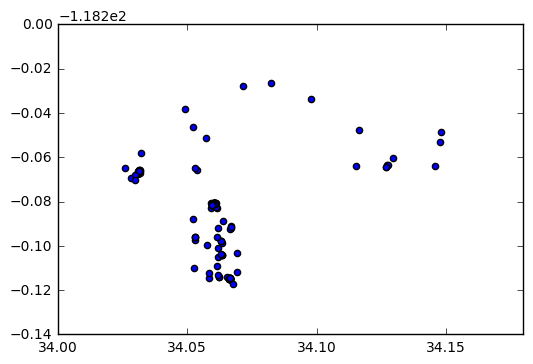

In [19]:
# Rough scatter plot of initial dataset 

plt.scatter(X,y)

In [20]:
from sklearn import preprocessing

In [21]:
X_scaled = preprocessing.scale(X)
y_scaled = preprocessing.scale(y)

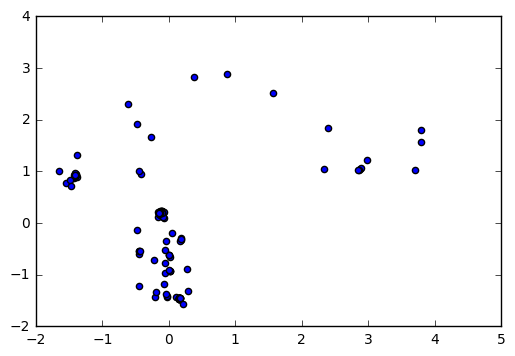

In [22]:
plt.scatter(X_scaled, y_scaled)

In [23]:
gloc_hist_alt = pandify_gloc_data(g_loc_hist2_raw['locations'],gmaps_columns,gmaps_coord_disp)

In [24]:
gloc_hist_alt.head(4)

,timestamp,lat,lng,acc,vel,heading,altitude,v_acc
0,2016-11-07 18:07:21,34.066386,-118.314777,5,0,0,63,16
1,2016-11-07 18:07:21,34.066391,-118.314760,34,0,0,0,0
2,2016-11-07 17:23:39,34.036402,-118.308978,10,2,238,58,24
3,2016-11-07 14:43:53,34.031227,-118.265898,53,0,0,0,0


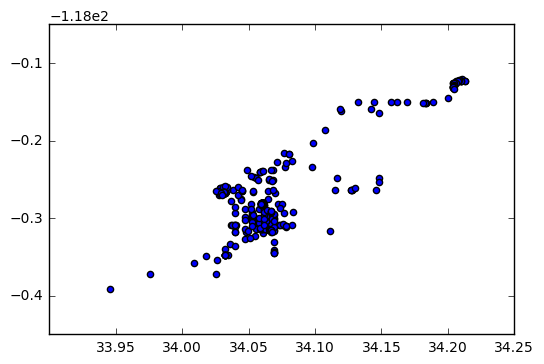

In [25]:
# Rough scatter plot

plt.scatter(gloc_hist_alt['lat'],gloc_hist_alt['lng'])

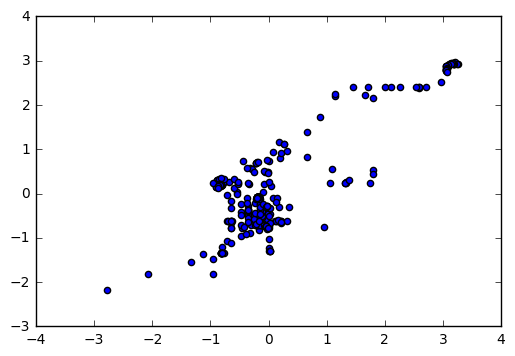

In [26]:
# Re-scaled scatter plot

plt.scatter(preprocessing.scale(np.array(gloc_hist_alt['lat'])), \
            preprocessing.scale(np.array(gloc_hist_alt['lng'])))

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import cluster, preprocessing, metrics

In [28]:
geoc = np.array(gloc_hist_alt[['lat','lng']])

In [29]:
kmlist = []

for n in range(2,100):
    lkm = KMeans(n_clusters=n)
    ltkm = lkm.fit(geoc)
    ltkm_score = metrics.silhouette_score(geoc, ltkm.labels_, metric='euclidean')
    kmlist.append([n,ltkm_score])
    #print "K:%s - Silhouette:%s"%(n,ltkm_score)

In [129]:
dir(ltkm)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getstate__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_fit_data',
 '_check_test_data',
 '_estimator_type',
 '_get_param_names',
 '_transform',
 'algorithm',
 'cluster_centers_',
 'copy_x',
 'fit',
 'fit_predict',
 'fit_transform',
 'get_params',
 'inertia_',
 'init',
 'labels_',
 'max_iter',
 'n_clusters',
 'n_init',
 'n_iter_',
 'n_jobs',
 'precompute_distances',
 'predict',
 'random_state',
 'score',
 'set_params',
 'tol',
 'transform',
 'verbose']

In [30]:
klist = np.array(kmlist)

In [31]:
np.amax(klist[3:100,1])

0.69958998756695101

In [32]:
for n in klist:
    if n[1]==np.amax(klist[3:100,1]):
        n_max =n[0]
        sc_max = np.amax(klist[3:100,1])
        print "n-cluster matching max sil score : %s"%n[0]

n-cluster matching max sil score : 45.0


(0.5, 0.725)

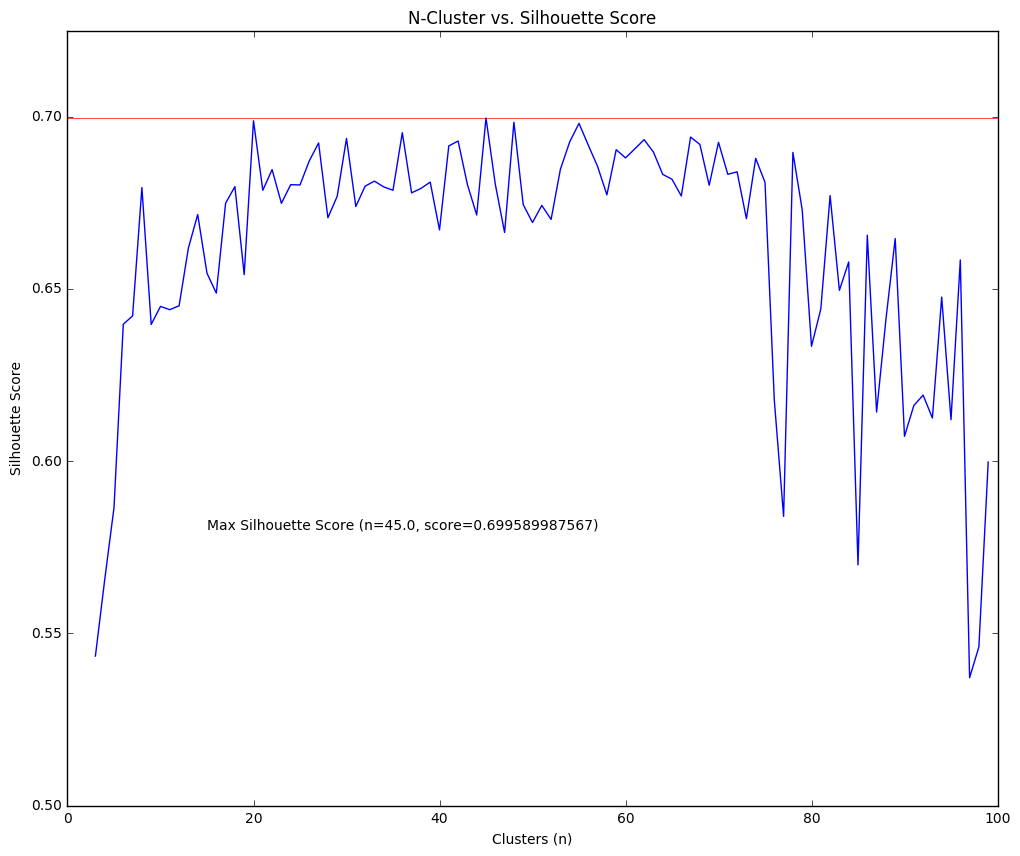

In [33]:
plt.figure(figsize=(12,10))
plt.plot(klist[1:,0],klist[1:,1])
plt.axhline(y=sc_max,c="red",linewidth=0.5,zorder=0)
plt.annotate('Max Silhouette Score (n=%s, score=%s)'%(n_max,sc_max), xy=(n_max, sc_max), xytext=(15, 0.58))
plt.title("N-Cluster vs. Silhouette Score")
plt.xlabel("Clusters (n)")
plt.ylabel("Silhouette Score")
plt.ylim(.5, 0.725)

In [34]:
lkm = KMeans(n_clusters=int(n_max))

In [35]:
ltkm = lkm.fit(geoc)

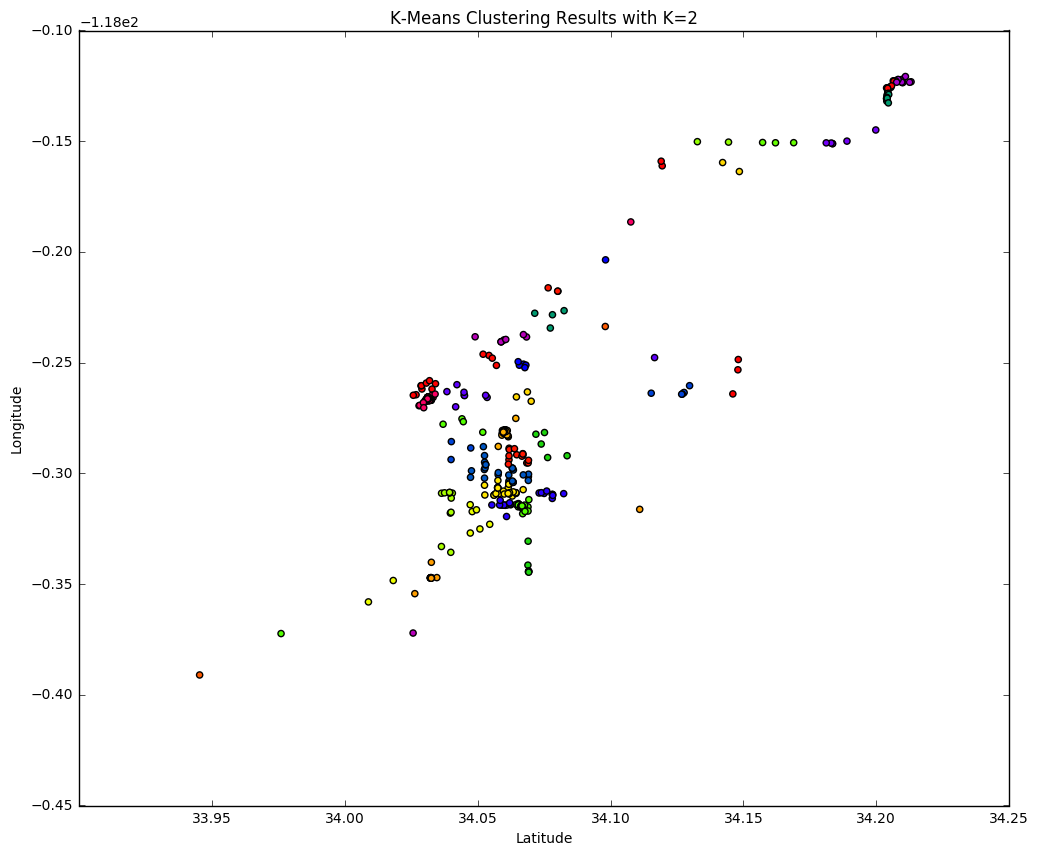

In [36]:
plt.figure(figsize=(12,10))
plt.scatter(geoc[:,0], geoc[:,1], c=ltkm.labels_, cmap=plt.cm.prism) 
plt.title('K-Means Clustering Results with K=2')
#plt.scatter(ltkm.cluster_centers_[:,0], ltkm.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)
plt.xlabel("Latitude")
plt.ylabel("Longitude")


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

my_tsne = TSNE(n_components=2)

geoc_stand = StandardScaler().fit_transform(geoc)

loc_tsne = my_tsne.fit_transform(geoc_stand)

loc_tsne_df = pd.DataFrame({'X1':loc_tsne[:,0], 'X2':loc_tsne[:,1],'y':ltkm.labels_})

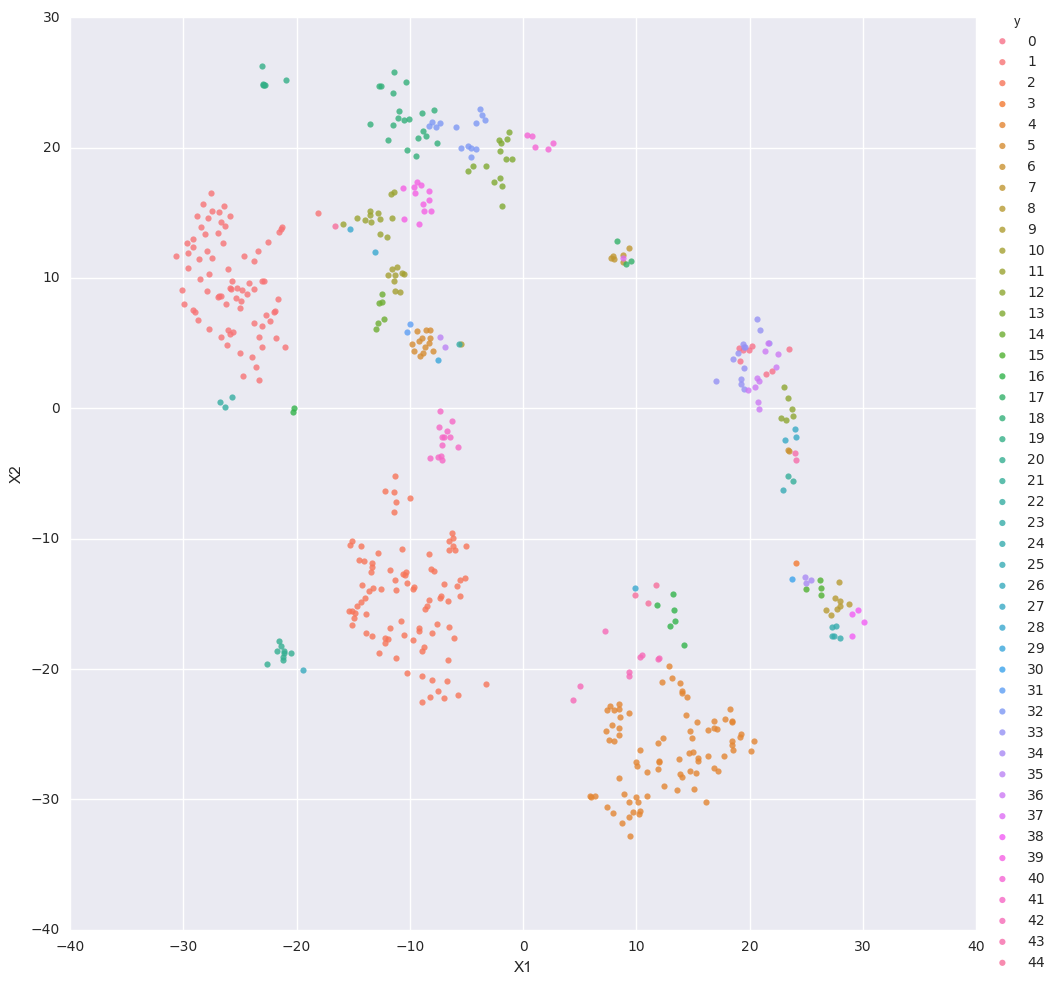

In [38]:
import seaborn as sns

sns.lmplot('X1','X2',data=loc_tsne_df, fit_reg=False,hue='y', size=10)

In [39]:
print "Dataset Start: %s"%gloc_hist_alt.tail(1)['timestamp'].values
print "Dataset Finish: %s"%gloc_hist_alt.head(1)['timestamp'].values

Dataset Start: ['2016-10-28 08:33:21']
Dataset Finish: ['2016-11-07 18:07:21']


### Section Conclusion

Though it may seem like a relatively high optimal 'n' given the number of data points, it is not outside the realm of reason that a user may have been located that many number of places over the timeframe of the data (11 days). 

Given that the points represent actual locations, the interpretation of the scatterplot is that during the observation period, the user traveled mainly between two points, but spent a lot of time in places inbetween the two points. The TSNE plot reveals that of the locations, there may be specific points of interest within the overall location data. 

This is ideal as we can work towards identifying those points of interest (POI) that the user may have a higher chance of recalling correctly. An "insignificant datapoint" (ie: data collected while the user was either in transit or sitting in traffic) which although could be considered a predictor of user behavior (ie: during evening commute, there amy be a point in the travel path in which there may be excessive traffic), may not be a particular point of interest for generating an LBC. User may not be able to easily recall the answer to "Where are you usually located at around XX:XX AM/PM?" if that location is a particular intersection. If a location is known/trained such as "home" or the name of the company where they work, the user may be more likely to recall the correct answer.

###  ------------ END of LBC Subsection - EDA - Dimension Validation ---------------

###  ------------ LBC Subsection - EDA - Finding POI ---------------

In [124]:
# For the purposes of placing the user at a specific time, we will not need the velocity and heading. 
# For now, we will keep accuracy and vertical accuracy figures.

In [40]:
gloc_hist_alt = gloc_hist_alt.drop(['vel'], axis=1).drop(['altitude'], axis=1)

In [41]:
gloc_hist_alt.head(10)

,timestamp,lat,lng,acc,heading,v_acc
0,2016-11-07 18:07:21,34.066386,-118.314777,5,0,16
1,2016-11-07 18:07:21,34.066391,-118.314760,34,0,0
2,2016-11-07 17:23:39,34.036402,-118.308978,10,238,24
3,2016-11-07 14:43:53,34.031227,-118.265898,53,0,0
4,2016-11-07 14:06:17,34.031402,-118.265722,77,0,10
5,2016-11-07 13:40:24,34.031327,-118.266530,10,305,6
6,2016-11-07 08:57:21,34.031385,-118.266618,62,0,0
7,2016-11-07 08:57:02,34.032807,-118.261937,2000,0,20
8,2016-11-07 08:06:54,34.052506,-118.298265,10,0,16
9,2016-11-06 23:11:02,34.066417,-118.314795,27,0,0


In [42]:
gloc_hist_alt['poi_id'] = ltkm.labels_

In [43]:
gloc_hist_alt.head(10)

,timestamp,lat,lng,acc,heading,v_acc,poi_id
0,2016-11-07 18:07:21,34.066386,-118.314777,5,0,16,2
1,2016-11-07 18:07:21,34.066391,-118.314760,34,0,0,2
2,2016-11-07 17:23:39,34.036402,-118.308978,10,238,24,10
3,2016-11-07 14:43:53,34.031227,-118.265898,53,0,0,4
4,2016-11-07 14:06:17,34.031402,-118.265722,77,0,10,4
5,2016-11-07 13:40:24,34.031327,-118.266530,10,305,6,4
6,2016-11-07 08:57:21,34.031385,-118.266618,62,0,0,4
7,2016-11-07 08:57:02,34.032807,-118.261937,2000,0,20,42
8,2016-11-07 08:06:54,34.052506,-118.298265,10,0,16,11
9,2016-11-06 23:11:02,34.066417,-118.314795,27,0,0,2


Based on the following degree precision information (Source: Wikipedia, https://en.wikipedia.org/wiki/Decimal_degrees), add locations with reduced accuracy within reasonable tolerances for clustering options.

![title](gps-resolution.png)

In [44]:
gloc_hist_alt['lat4'] = [round(glat,4) for glat in gloc_hist_alt['lat']]

In [45]:
gloc_hist_alt['lng4'] = [round(glng,4) for glng in gloc_hist_alt['lng']]

In [46]:
gloc_hist_alt['lat5'] = [round(glat,5) for glat in gloc_hist_alt['lat']]

In [47]:
gloc_hist_alt['lng5'] = [round(glng,5) for glng in gloc_hist_alt['lng']]

In [48]:
gloc_hist_alt.head(10)

,timestamp,lat,lng,acc,heading,v_acc,poi_id,lat4,lng4,lat5,lng5
0,2016-11-07 18:07:21,34.066386,-118.314777,5,0,16,2,34.0664,-118.3148,34.06639,-118.31478
1,2016-11-07 18:07:21,34.066391,-118.314760,34,0,0,2,34.0664,-118.3148,34.06639,-118.31476
2,2016-11-07 17:23:39,34.036402,-118.308978,10,238,24,10,34.0364,-118.3090,34.03640,-118.30898
3,2016-11-07 14:43:53,34.031227,-118.265898,53,0,0,4,34.0312,-118.2659,34.03123,-118.26590
4,2016-11-07 14:06:17,34.031402,-118.265722,77,0,10,4,34.0314,-118.2657,34.03140,-118.26572
5,2016-11-07 13:40:24,34.031327,-118.266530,10,305,6,4,34.0313,-118.2665,34.03133,-118.26653
6,2016-11-07 08:57:21,34.031385,-118.266618,62,0,0,4,34.0314,-118.2666,34.03138,-118.26662
7,2016-11-07 08:57:02,34.032807,-118.261937,2000,0,20,42,34.0328,-118.2619,34.03281,-118.26194
8,2016-11-07 08:06:54,34.052506,-118.298265,10,0,16,11,34.0525,-118.2983,34.05251,-118.29826
9,2016-11-06 23:11:02,34.066417,-118.314795,27,0,0,2,34.0664,-118.3148,34.06642,-118.31479


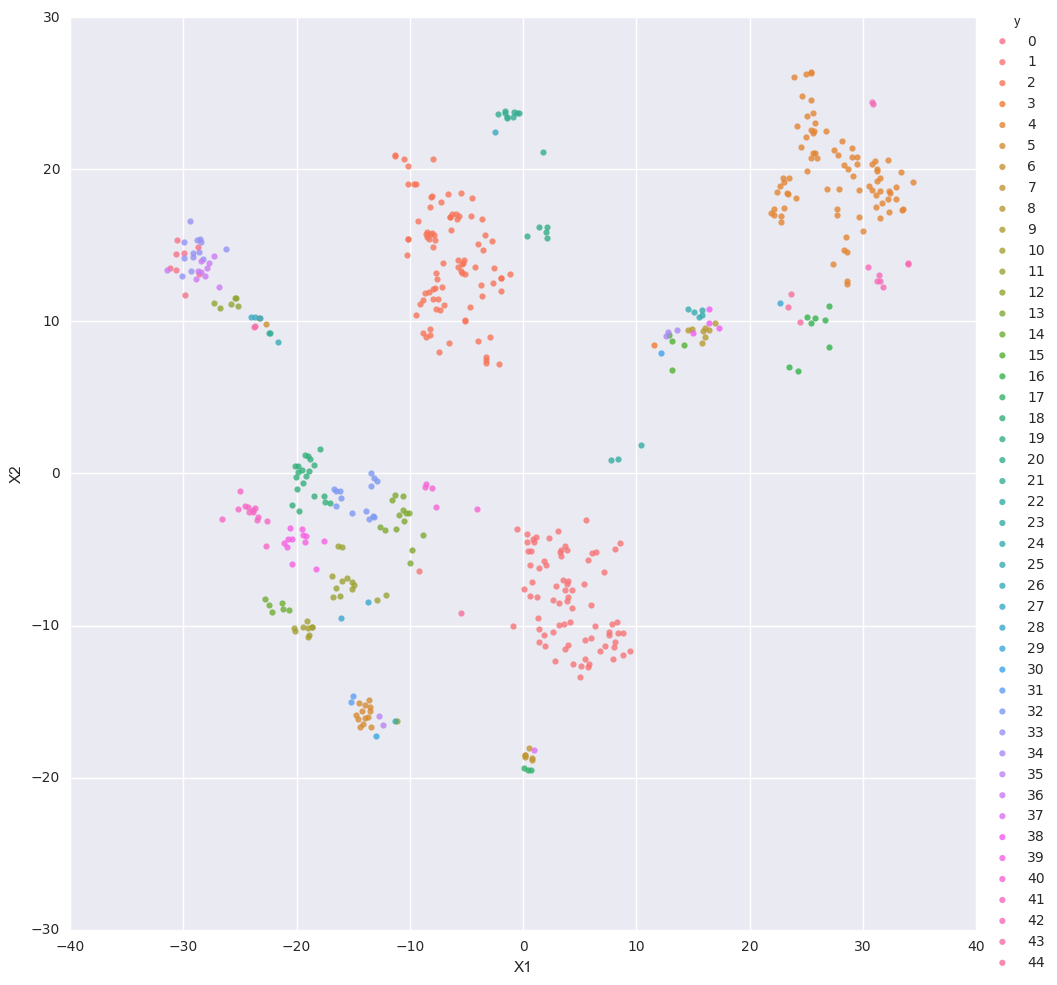

In [49]:
gloc4_tsne = TSNE(n_components=2)
geoc4_stand = StandardScaler().fit_transform(gloc_hist_alt[['lat4','lng4']])

loc4_tsne = gloc4_tsne.fit_transform(geoc4_stand)
loc4_tsne_df = pd.DataFrame({'X1':loc4_tsne[:,0], 'X2':loc4_tsne[:,1],'y':ltkm.labels_})

sns.lmplot('X1','X2',data=loc4_tsne_df, fit_reg=False,hue='y', size=10)

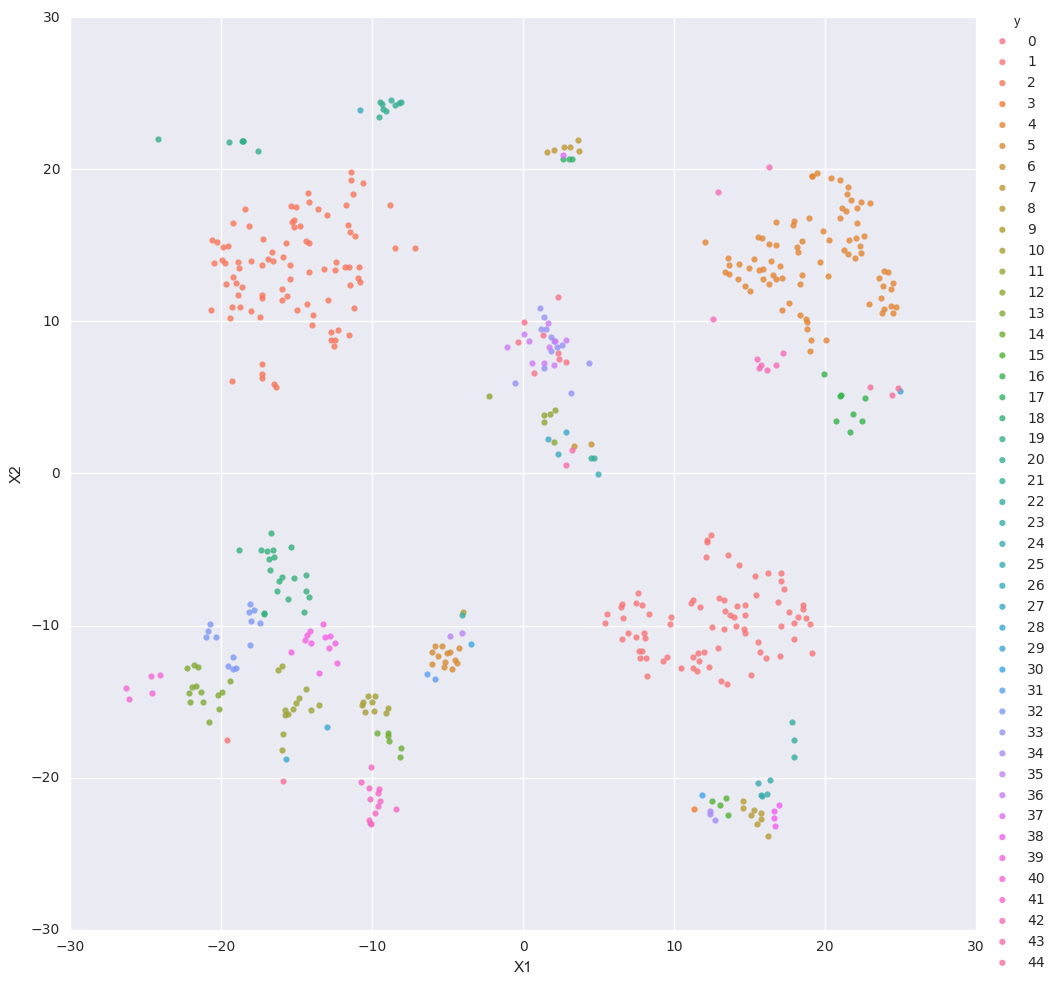

In [50]:
gloc5_tsne = TSNE(n_components=2)
geoc5_stand = StandardScaler().fit_transform(gloc_hist_alt[['lat5','lng5']])

loc5_tsne = gloc5_tsne.fit_transform(geoc5_stand)
loc5_tsne_df = pd.DataFrame({'X1':loc5_tsne[:,0], 'X2':loc5_tsne[:,1],'y':ltkm.labels_})

sns.lmplot('X1','X2',data=loc5_tsne_df, fit_reg=False,hue='y', size=10)

In [51]:
poi_id_list = gloc_hist_alt['poi_id'].value_counts().to_frame(name='Count').reset_index()

In [52]:
poi_id_list.head(10)

,index,Count
0,2,89
1,4,82
2,1,79
3,18,20
4,32,14
5,13,14
6,41,13
7,5,13
8,33,13
9,11,13


In [53]:
poi_sig = poi_id_list['Count'].describe()

In [54]:
poi_sig

count    45.000000
mean     11.155556
std      20.083865
min       1.000000
25%       2.000000
50%       5.000000
75%      10.000000
max      89.000000
Name: Count, dtype: float64

In [56]:
min_sig = poi_sig.ix['mean']+poi_sig.ix['std']

if len(poi_id_list[(poi_id_list['Count']>min_sig)]['index'].values) < 2:
    min_sig = poi_sig.ix['mean']+poi_sig.ix['std']
else:
    min_sig = poi_sig.ix['mean']+(poi_sig.ix['std']*2)

In [82]:
poi_points = poi_id_list[(poi_id_list['Count']>min_sig)]['index'].values

In [84]:
poi_points

array([2, 4, 1])

In [56]:
# The value counts of the POI id's shows us there are three locations in particular that may be of 
# high interest to the user. 

In [58]:
def showmap(maplat,maplng,zoom=16):

    from IPython.display import IFrame
    from IPython.core.display import display

    # Google Maps URL template for an iframe

    maps_url = "http://maps.google.com/maps?q={0}+{1}&z={2}&output=embed".format(maplat,maplng,zoom)
    print maps_url

    display(IFrame(maps_url, '400px', '300px'))

In [99]:
# Sample Geographic Location Visualization

#for n in poi_id_list[:5]['index']:
for n in poi_points:

    mean_lat = gloc_hist_alt[(gloc_hist_alt['poi_id']==n)]['lat'].mean()
    mean_lng = gloc_hist_alt[(gloc_hist_alt['poi_id']==n)]['lng'].mean()

    print mean_lat,mean_lng
    showmap(mean_lat,mean_lng)

34.0664876966 -118.314874163
http://maps.google.com/maps?q=34.0664876966+-118.314874163&z=16&output=embed


34.0312947305 -118.26638861
http://maps.google.com/maps?q=34.0312947305+-118.26638861&z=16&output=embed


34.0602851304 -118.281151108
http://maps.google.com/maps?q=34.0602851304+-118.281151108&z=16&output=embed


###  ------------ END of LBC Subsection - EDA - Finding POI ---------------

In [ ]:
# Next thing to do :
# Break down timestamps for each location and run cluster on timestamps to see if there is periodic significance

In [66]:
gloc_hist_alt['timestamp'] = pd.to_datetime(gloc_hist_alt['timestamp'])

In [285]:
gloc_hist_alt['dotw'] = [gldt.dayofweek for gldt in gloc_hist_alt['timestamp']]
gloc_hist_alt['hotd'] = [gldt.hour for gldt in gloc_hist_alt['timestamp']]

In [286]:
gloc_hist_alt.head(4)

,timestamp,lat,lng,acc,heading,v_acc,poi_id,lat4,lng4,lat5,lng5,dotw,hotd
0,2016-11-07 18:07:21,34.066386,-118.314777,5,0,16,2,34.0664,-118.3148,34.06639,-118.31478,0,18
1,2016-11-07 18:07:21,34.066391,-118.314760,34,0,0,2,34.0664,-118.3148,34.06639,-118.31476,0,18
2,2016-11-07 17:23:39,34.036402,-118.308978,10,238,24,10,34.0364,-118.3090,34.03640,-118.30898,0,17
3,2016-11-07 14:43:53,34.031227,-118.265898,53,0,0,4,34.0312,-118.2659,34.03123,-118.26590,0,14


6    28
5    20
4    12
2     9
0     9
1     6
3     5
Name: dotw, dtype: int64
18    11
8      8
19     7
17     7
2      7
23     6
21     6
20     6
15     5
22     5
9      5
7      4
0      4
10     3
1      2
13     2
11     1
Name: hotd, dtype: int64
count    89.000000
mean     13.921348
std       7.176706
min       0.000000
25%       8.000000
50%      17.000000
75%      20.000000
max      23.000000
Name: hotd, dtype: float64
Axes(0.125,0.125;0.775x0.775)


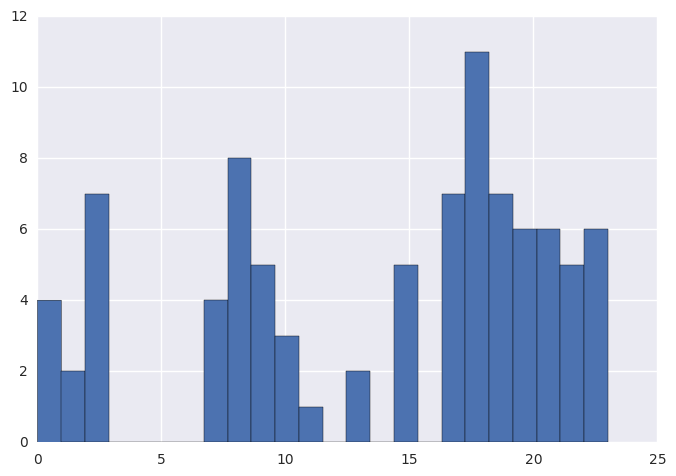

1    22
0    18
4    16
3    15
2    11
Name: dotw, dtype: int64
13    31
8     13
17    10
9      8
14     7
16     4
10     4
15     2
12     2
11     1
Name: hotd, dtype: int64
count    82.000000
mean     12.390244
std       2.887846
min       8.000000
25%       9.250000
50%      13.000000
75%      14.000000
max      17.000000
Name: hotd, dtype: float64
Axes(0.125,0.125;0.775x0.775)


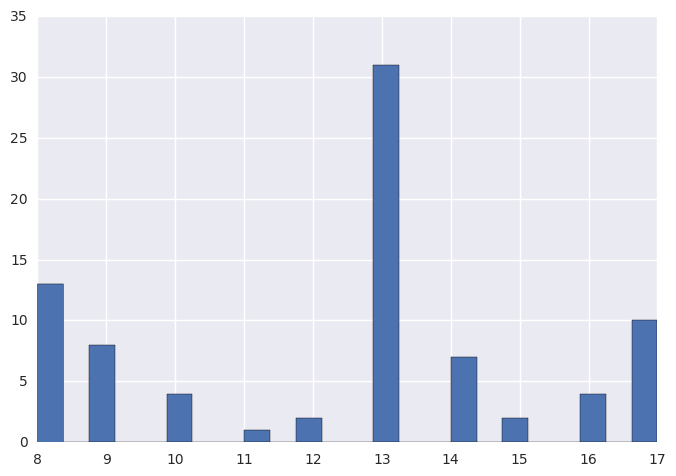

6    46
5    32
0     1
Name: dotw, dtype: int64
12    16
11    11
13     9
9      9
19     7
21     6
20     5
17     5
22     3
14     3
15     2
10     2
23     1
Name: hotd, dtype: int64
count    79.000000
mean     14.379747
std       4.216280
min       9.000000
25%      11.000000
50%      13.000000
75%      19.000000
max      23.000000
Name: hotd, dtype: float64
Axes(0.125,0.125;0.775x0.775)


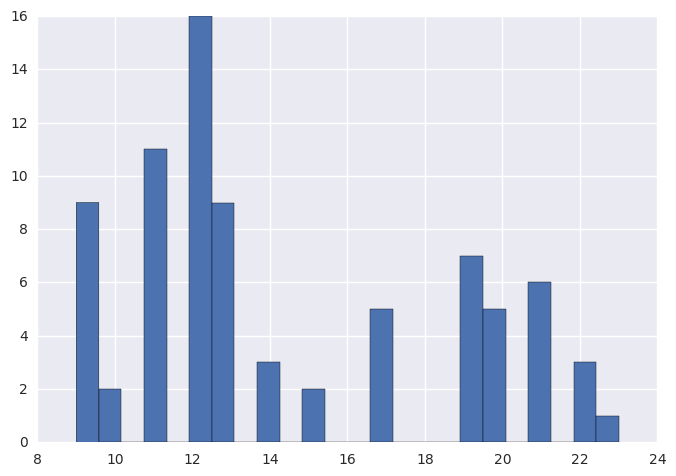

In [341]:
for n in poi_points:
    print gloc_hist_alt[(gloc_hist_alt['poi_id']==n)]['dotw'].value_counts()
    print gloc_hist_alt[(gloc_hist_alt['poi_id']==n)]['hotd'].value_counts()
    print gloc_hist_alt[(gloc_hist_alt['poi_id']==n)]['hotd'].describe()
    print gloc_hist_alt[(gloc_hist_alt['poi_id']==n)]['hotd'].hist(bins=24)
    plt.show()

In [339]:
gloc_hist_alt[(gloc_hist_alt['poi_id']==4)]['hotd'].describe()

count    82.000000
mean     12.390244
std       2.887846
min       8.000000
25%       9.250000
50%      13.000000
75%      14.000000
max      17.000000
Name: hotd, dtype: float64

In [283]:
gloc_hist_alt[(gloc_hist_alt['poi_id']==1)]

,timestamp,lat,lng,acc,heading,v_acc,poi_id,lat4,lng4,lat5,lng5,dotw
25,2016-11-06 17:35:40,34.061512,-118.283476,10,304,12,1,34.0615,-118.2835,34.06151,-118.28348,6
26,2016-11-06 17:35:10,34.060398,-118.280956,53,0,0,1,34.0604,-118.2810,34.06040,-118.28096,6
27,2016-11-06 17:29:47,34.060536,-118.281483,10,219,3,1,34.0605,-118.2815,34.06054,-118.28148,6
28,2016-11-06 17:27:15,34.059240,-118.281860,89,0,13,1,34.0592,-118.2819,34.05924,-118.28186,6
29,2016-11-06 17:24:51,34.060500,-118.280628,65,0,10,1,34.0605,-118.2806,34.06050,-118.28063,6
30,2016-11-06 15:42:09,34.060717,-118.281144,65,0,10,1,34.0607,-118.2811,34.06072,-118.28114,6
31,2016-11-06 15:35:54,34.059914,-118.281152,45,0,4,1,34.0599,-118.2812,34.05991,-118.28115,6
32,2016-11-06 14:34:15,34.059830,-118.280843,10,205,4,1,34.0598,-118.2808,34.05983,-118.28084,6
33,2016-11-06 14:24:00,34.060823,-118.280818,100,18,4,1,34.0608,-118.2808,34.06082,-118.28082,6
34,2016-11-06 14:09:09,34.060628,-118.281162,30,306,4,1,34.0606,-118.2812,34.06063,-118.28116,6


In [281]:
for poi_loc in poi_points:
    print gloc_hist_alt[(gloc_hist_alt['poi_id']==poi_loc)]['dotw'].value_counts()
    print gloc_hist_alt[(gloc_hist_alt['poi_id']==poi_loc)]['dotw'].describe()

6    28
5    20
4    12
2     9
0     9
1     6
3     5
Name: dotw, dtype: int64
count    89.000000
mean      3.988764
std       2.053237
min       0.000000
25%       2.000000
50%       5.000000
75%       6.000000
max       6.000000
Name: dotw, dtype: float64
1    22
0    18
4    16
3    15
2    11
Name: dotw, dtype: int64
count    82.000000
mean      1.865854
std       1.455192
min       0.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       4.000000
Name: dotw, dtype: float64
6    46
5    32
0     1
Name: dotw, dtype: int64
count    79.000000
mean      5.518987
std       0.798408
min       0.000000
25%       5.000000
50%       6.000000
75%       6.000000
max       6.000000
Name: dotw, dtype: float64


## Source: Facebook/Instagram

In [ ]:
locations = {}

messages = []
fb_loc = []

for post in unsealed['data']:
    try:
        fb_loc.append([post['name'],post['created_time'],post['place']['location']])
    except:
        pass


In [ ]:
fb_loc

## === Question : How to tie in location data across sources to build an LBC? ===

Algorithm angles of attack:
1. Correlation between posts with location data vs. all posts
    - With what frequency (or "importance") does the user tie-in location data to their digital footprint?
        - Check-ins, place mentions, instagram posts with tags, maps history frequencies, etc. 

# =============== END LBC ================

In [ ]:
user_features = TfidfVectorizer(stop_words='english',
                               strip_accents='ascii')

In [ ]:
X_features = user_features.fit_transform(messages)

In [ ]:
#user_features.vocabulary_

## === LBC Generation ===

This is a rough implementation of the Location Based Challenge module for SG1. 

Expected final implementation will be a LBC class which will include measures to destroy the instance after use or upon expiration so that data does not reside in memory. 

In [241]:
# Password tokenization

import time
import hashlib

# Run Once
#testdev = ''.join(random.choice('0123456789') for i in range(15))   # 15-digit length of IMEI
#testdev = testdev + testdev[0] # Add copy of first digit to create 16-digit key

token = 'a'

def tokemon(devid = testdev):
    to_encode = devid + str(int(round(time.time())))
    encoded = hashlib.sha224(to_encode).hexdigest()
    global token
    token = encoded
    return token

In [274]:
# Version 0.1 - Basic LBC generation based on assumed data from above. 

# No parameters
# Data is assumed to inherently exist from processing/model applications above.
# This version of LBC is basing geolocation information solely from GPS coordinates
# obtained via Google Maps background locator data.

# Function will return LBC with hint if available along with randomized token for answer tokenization. 

# Secondary function will take LBC challenge answer and token and repond with authentication response. 

valid_answer = 'testing'

def genlbc():
    
    # There are different "classes" of location oriented questions that can be generated based
    # on user location behavior modeling. 
    
    # Location Frequency - What day(s) are you usually at {%location}?
    # Significant POI - On {%dotw}, where do you go most often? 

    # V0.2 - planned algorithms
    # Checked in POI - On {%dotw - expressed as "last {%dotw}}, where did you check in
    #                  for {%significant_event}
    #       > For significant event, look up place category (food, show/theater, etc)
    #         and cross reference TOD to obtain likely type of event for which the
    #         user checked in (ie: dinner, show/concert, etc)
    #       > This will need to try to avoid Facebook check-ins as much as possible
    #         as this type of security measure will be circumvented if the answers are
    #         plainly visible on a public feed. LBC should be generated with as user-specific
    #         data as possible that is not public.
    
    
    
    
    
    
    hint = "none"
    
    challenge = ["This will be the query.", hint]
    global token 
    gen_token = tokemon()
    
    return challenge, gen_token

In [279]:
def passlbc(answer,passed_token):
    
    # Validate token first
    
    if passed_token != token:
        return 0
    else:
        global valid_answer
        if answer==valid_answer:
            return 1
        if answer!=valid_answer:
            return -1

In [280]:
# Test function to query user and try authenticating.
import string


def lbc_auth():

    lbc_query,lbc_token = genlbc()
    for attempt_number in range(0,3):
        if attempt_number > 0:
            try:
                # Show user a hint if available
                if lbc_query[1]!="none":
                    print lbc_query[0]
                    raw_response = raw_input(hint)
                else:
                    raw_response = raw_input(lbc_query[0])
            except:
                # No hint available
                raw_response = raw_input(lbc_query[0])
        else:
            raw_response = raw_input(lbc_query[0])            
        response = raw_response.lower().translate(None, string.punctuation)
        attempt = passlbc(response,lbc_token)
        if attempt==1:
            print "Login OK - You have been identified as an authorized user."
            break
        elif attempt==-1:
            print "Authenticated failed. Please try again."
        elif attempt==0:
            print "Insecure authentication attempt detected. System may be compromised."
            break
    if attempt_number==2:
        print "Authentication failed."

## === LBC Tests ===

In [278]:
lbc_auth()

This will be the query.test ting
Authenticated failed. Please try again.
This will be the query.testing
You have been identified as an authorized user.
